### Bayes by Backprop (Weight Uncertainty in Neural Networks)

#### Toy example

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

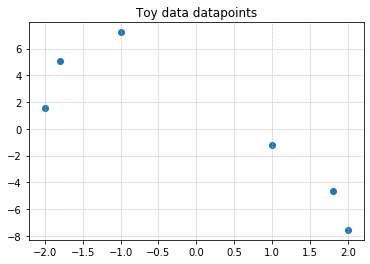

In [11]:
def toy_function(x):
    return -x**4 + 3*x**2 -5*np.sin(x) + 1

# toy dataset we can start with
x = torch.tensor([-2, -1.8, -1, 1, 1.8, 2]).reshape(-1,1)
y = toy_function(x)

plt.scatter(x, y)
plt.title('Toy data datapoints')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [12]:
class standard_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1,16)
        self.l2 = nn.Linear(16,16)
        self.l3 = nn.Linear(16,1)
    def forward(self, x):
        x = self.l3(F.sigmoid(self.l2(F.sigmoid(self.l1(x)))))
        return x

In [13]:
# initialization of our standard neural network
net1 = standard_MLP()#.to(device)

# use of a Mean Square Error loss to evaluate the network because we are in a regression problem
criterion = nn.MSELoss()

# use of stochastic gradient descent as our optimizer
optimizer = optim.SGD(net1.parameters(), lr=0.01)

# number of times we are looping over our data to train the network
epochs = 30000

for epoch in range(epochs):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net1(x.to(device))    # pass the data forward
    loss = criterion(output, y.to(device))   # evaluate our performance
    if epoch % 5000 == 0:
        print("epoch {} loss: {}".format(epoch,loss))
    loss.backward()  # calculates the gradients
    optimizer.step()    # updates weigths of the network

/home/ash/anaconda3/envs/rnd/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss: 26.570823669433594
epoch 5000 loss: 1.1363357305526733
epoch 10000 loss: 0.34066644310951233
epoch 15000 loss: 0.15033920109272003
epoch 20000 loss: 0.03339933976531029
epoch 25000 loss: 0.003701691748574376


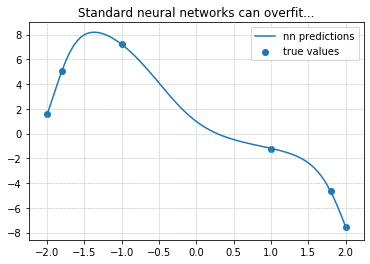

In [14]:
x_test = torch.linspace(-2,2,100).reshape(-1,1)
predictions = net1(x_test.to(device))
plt.plot(x_test.numpy(), predictions.cpu().detach().numpy(), label = 'nn predictions')
plt.scatter(x, y, label = 'true values')
plt.title('Standard neural networks can overfit...')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

- When we extend predictions beyond the range of our data, we clear see that we are overfitting to the 6 data points.
    - It gets worse because x values of the extended range cna be regarded as 'out-of-distributions'. 
    - Overconfident generalization in areas without any training data

/home/ash/anaconda3/envs/rnd/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


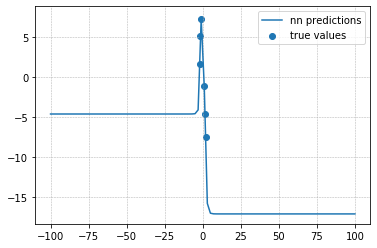

In [15]:
x_test = torch.linspace(-100,100,100).reshape(-1,1)
predictions = net1(x_test.to(device))
plt.plot(x_test.numpy(), predictions.cpu().detach().numpy(), label = 'nn predictions')
plt.scatter(x, y, label = 'true values')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

##### Predict with a Bayesian NN
- We can estimate $\mathbb{E}_{P(w \vert \mathcal{D})}\left[P(y \vert x, w)\right]$ by sampling from the posterior distribution $P(w \vert \mathcal{D})$ and for each sample, calculate $f(X \vert w)$ and average them.

##### Variational Inference
- Suppose that the variational posterior is a diagonal Gaussian distribution, then a sample of the weights w can be obtained by sampling a unit Gaussian.
-  Let's approximate each weight $w_i$ with a normal distribution with mean $\mu_i$ and standard deviation $\sigma_i$. We’ll denote all of these new parameters as $\theta = (\mu, \sigma)$, which defines a distribution over all the weights $q(w \vert \theta)$.

- Our goal, therefore, will be to minimize the KL divergence between $q(w \vert \theta)$ and $P(w \vert \mathcal{D})$. We are looking for $\theta^*$ such that,
$$\theta^* = \underset{\theta}{\mathrm{argmin}} \text{ KL}\left[q(w \vert \theta) \vert \vert P(w \vert \mathcal{D})\right]$$

\begin{aligned}
\theta^* &= \underset{\theta}{\mathrm{argmin}} \text{ KL}\left[q(w \vert \theta) \vert \vert P(w \vert \mathcal{D})\right] & \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta)\log\frac{ q(w \vert \theta) }{P( w \vert \mathcal{D})}dw & \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta) \log\frac{ q(w \vert \theta)P(\mathcal{D}) }{P( \mathcal{D} \vert w)P(w)} dw & \text{(Bayes Theorem)} \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta) \log\frac{ q(w \vert \theta) }{P( \mathcal{D} \vert w)P(w)} dw & \text{(Drop }P(\mathcal{D})\text{ because it doesn't depend on } \theta) \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ KL}\left[q(w \vert \theta) \vert \vert P(w)\right] - \mathbb{E}_{q(w \vert \theta)}\left[ \log P(\mathcal{D} \vert w) \right]
\end{aligned}

- $P(\mathcal{D} \vert w)$ is the likelihood of observing our data given our weights.
- $\text{ KL}\left[q(w \vert \theta) \vert \vert P(w)\right]$: We can interpret this KL-divergence term as a regularizer that encourages $q(w \vert \theta)$ to match the prior $P(w)$.
- **But can we use back propagation to minimize the KL divergence with respect to $\theta$?** We'll need to take a derivative of an expectation. 

- The authors suggest a reparameterization trick to do this.
    - $w_i = \mu_i + \sigma_i\times \epsilon_i$ where $\epsilon_i \sim \mathcal{N}(0,1)$. We can swap the derivative and the expectation because $w_i$ is a deterministic function of $\mu_i$ and $\sigma_i$ given $\epsilon_i$. In math this can be stated as:</p>

$$\frac{\partial}{\partial \theta}\mathbb{E}_{q(w)}\left[ \log\left[\frac{ q(w \vert \theta) }{P( \mathcal{D} \vert w)P(w)}\right]\right] =\mathbb{E}_{q(\epsilon)}\left[ \frac{\partial}{\partial \theta}\log\left[\frac{ q(w \vert \theta) }{P( \mathcal{D} \vert w)P(w)}\right]\right]$$
- Now $\epsilon$ and $\theta =(\mu, \sigma)$ are independent. We made the stochastic element in $q(w)$ independent of $\theta$, thus we can place the derivative inside the expectation. (and we're going to take a MC estimation by sampling a single $\epsilon$)
- One last thing before we go over the algorithm. We need to reparameterize $\sigma$ to the entire real line, not just positive values. We define $\sigma = \log(1+e^\rho)$.

In [16]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, x):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()
        
        return F.linear(x, self.w, self.b)

In [17]:
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden1 = Linear_BBB(1,hidden_units, prior_var=prior_var)
        self.hidden2 = Linear_BBB(hidden_units,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden1.log_prior + self.hidden2.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden1.log_post + self.hidden2.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)   # 이거를 to(device 안했더니 에러 났음. 왜?)
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss

In [18]:
net = MLP_BBB(16, prior_var=1).to(device)

In [19]:
optimizer = optim.Adam(net.parameters(), lr=.1)

In [20]:
epochs = 2000
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(x.to(device), y.to(device), 1)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 9714.564453125
epoch: 101/2000
Loss: 1629.5869140625
epoch: 201/2000
Loss: 1338.2724609375
epoch: 301/2000
Loss: 1441.2509765625
epoch: 401/2000
Loss: 1186.490966796875
epoch: 501/2000
Loss: 684.0037231445312
epoch: 601/2000
Loss: 679.91748046875
epoch: 701/2000
Loss: 653.4278564453125
epoch: 801/2000
Loss: 687.9876708984375
epoch: 901/2000
Loss: 608.541748046875
epoch: 1001/2000
Loss: 647.8386840820312
epoch: 1101/2000
Loss: 611.9576416015625
epoch: 1201/2000
Loss: 740.8626708984375
epoch: 1301/2000
Loss: 484.4271240234375
epoch: 1401/2000
Loss: 490.0362548828125
epoch: 1501/2000
Loss: 538.6090698242188
epoch: 1601/2000
Loss: 564.396728515625
epoch: 1701/2000
Loss: 497.5491027832031
epoch: 1801/2000
Loss: 646.4313354492188
epoch: 1901/2000
Loss: 558.5045166015625
Finished Training


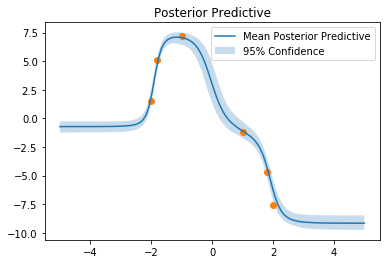

In [21]:
# samples is the number of "predictions" we make for 1 x-value.
samples = 100
x_tmp = torch.linspace(-5,5,100).reshape(-1,1).to(device)
y_samp = np.zeros((samples,100))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

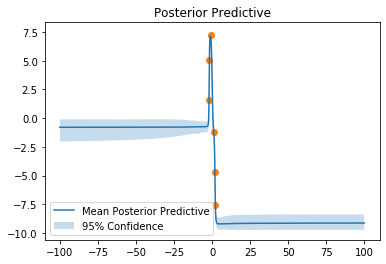

In [22]:
samples = 100
x_tmp = torch.linspace(-100,100,1000).reshape(-1,1).to(device)
y_samp = np.zeros((samples,1000))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()